In [ ]:
!pip install pyinform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install scienceplots

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from pyinform import transfer_entropy
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

In [ ]:
plt.rcParams.update({
    'font.size': 16,             # base font size for text
    'axes.titlesize': 18,        # axis title
    'axes.labelsize': 16,        # axis labels
    'xtick.labelsize': 14,       # x-tick labels
    'ytick.labelsize': 14,       # y-tick labels
    'legend.fontsize': 14,       # legend text
    'figure.titlesize': 20,      # overall figure title (if used)
})

In [ ]:
from typing import Dict

def simulate_herding_data(
    time_steps=30,
    num_mares=6,
    herding_start=11,
    herding_end=20,
    coefficients=None,
    grazing_std_dev=0.5,
    stallion_movement_distance=20,
    repulsion_stallion_distance=2,
    short_repulsion_distance=4,
    medium_attraction_distance=8,
    synchronization_distance=12,
    stallion_speed=2,
):

    if coefficients is None:
        coefficients = {}
        for i in range(1, num_mares + 1):
            coefficients[f"mare{i}"] = {
                "inertia": 0.5,
                "repulsion_stallion": 0.4,
                "short_repulsion": 0.3,
                "medium_attraction": 0.2,
                "synchronization": 0.2,
                "com_attraction": 0.5,
            }

    # Initialize stallion and mare positions and velocities
    stallion_pos = np.array([[0.0, 0.0]])
    mare_positions = {}
    mare_velocities = {}
    for i in range(1, num_mares + 1):
        # Random initial positions for mares
        mare_positions[f"mare{i}"] = [np.random.uniform(-2, 2, size=2)]
        # Initial velocity is zero
        mare_velocities[f"mare{i}"] = [np.array([0.0, 0.0])]

    # Initialize DataFrame for simulation data
    simulation_data = pd.DataFrame({"time": np.arange(1, time_steps + 1)})

    for t in range(1, time_steps + 1):
        # Stallion Movement
        if t < herding_start or t > herding_end:
            # Grazing: small random movement
            stallion_move = np.random.normal(0, grazing_std_dev, size=2)
        else:
            # Herding: move towards a random target
            if t == herding_start:
                target = np.random.uniform(-stallion_movement_distance, stallion_movement_distance, size=2)
                stallion_direction = target - stallion_pos[-1]
                stallion_direction /= np.linalg.norm(stallion_direction)
            stallion_move = stallion_speed * stallion_direction
        stallion_new_pos = stallion_pos[-1] + stallion_move
        stallion_pos = np.vstack([stallion_pos, stallion_new_pos])

        # Update mare positions
        if t < herding_start or t > herding_end:
            # Mares are grazing: small random movement
            for i in range(1, num_mares + 1):
                last_pos = mare_positions[f"mare{i}"][-1]
                grazing_move = np.random.normal(0, grazing_std_dev, size=2)
                new_vel = grazing_move
                new_pos = last_pos + new_vel
                mare_positions[f"mare{i}"].append(new_pos)
                mare_velocities[f"mare{i}"].append(new_vel)
        else:
            # Mares have complex behavior
            # Collect mare positions for calculations
            current_positions = []
            for i in range(1, num_mares + 1):
                current_positions.append(mare_positions[f"mare{i}"][-1])
            for i in range(1, num_mares):
                current_positions.append(stallion_pos[-1])
            current_positions = np.array(current_positions)

            # Calculate the center of mass (COM) of the mares
            com = np.mean(current_positions[:-1], axis=0)

            # Update each mare's position based on forces
            for i in range(1, num_mares + 1):
                coeffs = coefficients[f"mare{i}"]
                last_pos = mare_positions[f"mare{i}"][-1]
                last_vel = mare_velocities[f"mare{i}"][-1]

                # Inertia (normalized)
                if t == herding_start:
                    inertia_force = np.zeros(2)
                else:
                    inertia_force = last_vel
                inertia_force_norm = inertia_force / (np.linalg.norm(inertia_force) + 1e-6)

                # Repulsion from Stallion (normalized)
                vec_to_stallion = last_pos - stallion_pos[-1]
                dist_to_stallion = np.linalg.norm(vec_to_stallion)
                if dist_to_stallion < repulsion_stallion_distance:
                    repulsion_stallion_force = vec_to_stallion / (dist_to_stallion + 1e-6)
                else:
                    repulsion_stallion_force = np.zeros(2)

                # Short-Range Repulsion from other mares (normalized)
                short_repulsion_force = np.zeros(2)
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = last_pos - mare_positions[f"mare{j}"][-1]
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if dist_to_mare < short_repulsion_distance:
                            short_repulsion_force += vec_to_mare / (dist_to_mare + 1e-6)
                short_repulsion_force_norm = short_repulsion_force / (np.linalg.norm(short_repulsion_force) + 1e-6)

                # Medium-Range Attraction to other mares (normalized)
                medium_attraction_force = np.zeros(2)
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = mare_positions[f"mare{j}"][-1] - last_pos
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if short_repulsion_distance <= dist_to_mare < medium_attraction_distance:
                            medium_attraction_force += vec_to_mare / (dist_to_mare + 1e-6)
                medium_attraction_force_norm = medium_attraction_force / (np.linalg.norm(medium_attraction_force) + 1e-6)

                # Synchronization Attraction (normalized)
                synchronization_force = np.zeros(2)
                nearest_mare_vel = None
                min_dist = synchronization_distance
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = mare_positions[f"mare{j}"][-1] - last_pos
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if dist_to_mare < min_dist:
                            min_dist = dist_to_mare
                            nearest_mare_vel = mare_velocities[f"mare{j}"][-1]
                if nearest_mare_vel is not None:
                    synchronization_force = nearest_mare_vel
                    synchronization_force_norm = synchronization_force / (np.linalg.norm(synchronization_force) + 1e-6)
                else:
                    synchronization_force_norm = np.zeros(2)

                # Attraction to COM (normalized)
                vec_to_com = com - last_pos
                com_attraction_force = vec_to_com / (np.linalg.norm(vec_to_com) + 1e-6)

                # Combine forces with coefficients
                total_force = (
                    coeffs["inertia"] * inertia_force_norm
                    + coeffs["repulsion_stallion"] * repulsion_stallion_force
                    + coeffs["short_repulsion"] * short_repulsion_force_norm
                    + coeffs["medium_attraction"] * medium_attraction_force_norm
                    + coeffs["synchronization"] * synchronization_force_norm
                    + coeffs["com_attraction"] * com_attraction_force
                )
                total_force_norm = total_force / (np.linalg.norm(total_force) + 1e-6)

                # Update velocity and position
                speed = np.random.uniform(0.5, 1)  # Variable speed
                new_vel = speed * total_force_norm
                new_pos = last_pos + new_vel

                mare_positions[f"mare{i}"].append(new_pos)
                mare_velocities[f"mare{i}"].append(new_vel)

    # Collect simulation data
    for i in range(1, num_mares + 1):
        positions = np.array(mare_positions[f"mare{i}"])
        simulation_data[f"mare{i}_x"] = positions[1:, 0]
        simulation_data[f"mare{i}_y"] = positions[1:, 1]
    simulation_data["stallion_x"] = stallion_pos[1:, 0]
    simulation_data["stallion_y"] = stallion_pos[1:, 1]

    return simulation_data

def extract_features(simulation_data, num_mares=6):
    features = pd.DataFrame()
    features['time'] = simulation_data['time']
    avg_pairwise_dist = []
    std_pairwise_dist = []
    avg_distance_to_com = []

    for index, row in simulation_data.iterrows():
        # Extract positions of mares
        positions = []
        for i in range(1, num_mares + 1):
            x = row[f'mare{i}_x']
            y = row[f'mare{i}_y']
            positions.append([x, y])
        positions = np.array(positions)

        # Compute pairwise distances
        pairwise_dists = pdist(positions)
        avg_pairwise_dist.append(np.mean(pairwise_dists))
        std_pairwise_dist.append(np.std(pairwise_dists))

        # Center of mass
        com = np.mean(positions, axis=0)
        # Distance of each mare to COM
        distances_to_com = np.linalg.norm(positions - com, axis=1)
        avg_distance_to_com.append(np.mean(distances_to_com))

    features['avg_pairwise_dist'] = avg_pairwise_dist
    features['std_pairwise_dist'] = std_pairwise_dist
    features['avg_distance_to_com'] = avg_distance_to_com
    return features

def compute_movement_series(simulation_data, num_mares=6):
    # Compute movement (delta x, delta y) for stallion and mares
    movement_data = pd.DataFrame()
    movement_data['time'] = simulation_data['time'][1:].reset_index(drop=True)

    # Stallion movement
    stallion_x = simulation_data['stallion_x']
    stallion_y = simulation_data['stallion_y']
    stallion_dx = stallion_x.diff().dropna().reset_index(drop=True)
    stallion_dy = stallion_y.diff().dropna().reset_index(drop=True)
    stallion_movement = np.sqrt(stallion_dx ** 2 + stallion_dy ** 2)
    movement_data['stallion_movement'] = stallion_movement

    # Mares movement
    for i in range(1, num_mares + 1):
        mare_x = simulation_data[f'mare{i}_x']
        mare_y = simulation_data[f'mare{i}_y']
        mare_dx = mare_x.diff().dropna().reset_index(drop=True)
        mare_dy = mare_y.diff().dropna().reset_index(drop=True)
        mare_movement = np.sqrt(mare_dx ** 2 + mare_dy ** 2)
        movement_data[f'mare{i}_movement'] = mare_movement

    return movement_data

def discretize_series(series, bins=20):
    # Discretize a continuous series into specified number of bins
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    series = series.values.reshape(-1, 1)
    discretized_series = est.fit_transform(series).astype(int).flatten()
    return discretized_series

def compute_local_transfer_entropy(movement_data, k=1):
    # Get the list of horse names based on the movement columns
    horse_names = [col.replace('_movement', '') for col in movement_data.columns if col.endswith('_movement')]

    # Discretize the movement series for all horses
    horse_series = {horse: discretize_series(movement_data[f'{horse}_movement']) for horse in horse_names}

    # Find the minimum series length to ensure equal length after k-shift
    series_length = min(len(series) for series in horse_series.values())
    adjusted_length = series_length - k

    # Initialize an array to store aggregated LTE values
    total_lte = np.zeros(adjusted_length)
    num_pairs = 0

    # Compute LTE between all pairs of horses (excluding self-pairs)
    for source_horse in horse_names:
        for target_horse in horse_names:
            if source_horse != target_horse:
                source_series = horse_series[source_horse][:series_length]
                target_series = horse_series[target_horse][:series_length]
                # Compute LTE from source_horse to target_horse
                lte = transfer_entropy(source_series, target_series, k=k, local=True)
                # Aggregate LTE values
                total_lte += lte.reshape(-1)
                num_pairs += 1

    # Average LTE across all pairs
    avg_lte = total_lte / num_pairs
    # Adjust the movement data to align with the LTE values
    movement_data = movement_data.iloc[k:series_length].reset_index(drop=True)
    movement_data['local_transfer_entropy'] = avg_lte
    return movement_data

In [ ]:
def simulate_multiple_sequences(
    N,
    time_steps,
    num_mares,
    grazing_time_range,
    herding_duration_range,
    stallion_movement_distance,
    stallion_speed,
    grazing_std_dev=0.5,
    **kwargs
):
    """Create N simulation runs with random grazing/herding starts."""
    runs = []
    for _ in tqdm(range(N), desc="Simulating runs"):
        grazing_time = np.random.randint(*grazing_time_range)
        herding_duration = np.random.randint(*herding_duration_range)
        herding_start = grazing_time
        herding_end = grazing_time + herding_duration
        sim_data = simulate_herding_data(
            time_steps=time_steps,
            num_mares=num_mares,
            herding_start=herding_start,
            herding_end=herding_end,
            stallion_movement_distance=stallion_movement_distance,
            stallion_speed=stallion_speed,
            grazing_std_dev=grazing_std_dev,
            **kwargs
        )
        runs.append({
            "simulation_data": sim_data,
            "herding_start": herding_start,
            "herding_end": herding_end,
            "num_mares": num_mares
        })
    return runs

def compute_spatial_lte(sim_data, movement_data, k=1, threshold=5.0):
    mare_x_cols = sorted([c for c in sim_data.columns if c.startswith("mare") and c.endswith("_x")])
    mare_names = [c[:-2] for c in mare_x_cols]
    valid_idxs = []
    for idx, row in sim_data.iterrows():
        positions = [row[[f"{m}_x", f"{m}_y"]].values for m in mare_names]
        positions.append(row[["stallion_x", "stallion_y"]].values)
        if np.max(pdist(np.array(positions))) <= threshold:
            valid_idxs.append(idx)
    mov_idxs = [i-1 for i in valid_idxs if i-1 >= 0]
    masked_mov = movement_data.iloc[mov_idxs].reset_index(drop=True)
    return compute_local_transfer_entropy(masked_mov, k=k)

def compute_weighted_lte(sim_data, movement_data, k=1, d0=5.0):
    horse_cols = [c for c in movement_data.columns if c.endswith("_movement")]
    series_length = len(movement_data) - k
    total_weighted = np.zeros(series_length)
    count = 0
    for src in horse_cols:
        for tgt in horse_cols:
            if src == tgt:
                continue
            dists = []
            for i in range(1, len(sim_data)):
                p1 = sim_data.loc[i, [src.replace("_movement","_x"), src.replace("_movement","_y")]].values
                p2 = sim_data.loc[i, [tgt.replace("_movement","_x"), tgt.replace("_movement","_y")]].values
                dists.append(np.linalg.norm(p1 - p2))
            dists = np.array(dists)[k:]
            weights = np.exp(-dists / d0)
            lte = transfer_entropy(
                movement_data[src].values,
                movement_data[tgt].values,
                k=k, local=True
            ).reshape(-1)
            total_weighted += lte * weights
            count += 1
    weighted = total_weighted / count
    df = movement_data.iloc[k:].reset_index(drop=True)
    df["weighted_lte"] = weighted
    return df

def compute_cross_correlation(movement_data, window_size=5):
    half_w = window_size // 2
    cc_vals, times = [], []
    mare_cols = [c for c in movement_data.columns if c.startswith("mare") and c.endswith("_movement")]
    for i in range(half_w, len(movement_data) - half_w):
        win = movement_data.iloc[i-half_w:i+half_w+1]
        stall = win["stallion_movement"]
        corrs = [stall.corr(win[m]) for m in mare_cols]
        cc_vals.append(np.nanmean(corrs))
        times.append(movement_data.loc[i, "time"])
    return pd.DataFrame({"time": times, "cross_correlation": cc_vals})

In [ ]:
def run_analysis(
    runs,
    k_list,
    spatial_threshold,
    d0,
    cc_window_sizes,
    cc_threshold=0.5
):
    records = []
    for run in tqdm(runs, desc="Analyzing runs"):
        sim = run["simulation_data"]
        g0, g1 = run["herding_start"], run["herding_end"]
        mov = compute_movement_series(sim, run["num_mares"])

        for k in k_list:
            te_df = compute_local_transfer_entropy(mov.copy(), k=k)
            thr = te_df.local_transfer_entropy.mean() + te_df.local_transfer_entropy.std()
            pred = te_df.local_transfer_entropy >= thr
            true = te_df.time.between(g0, g1)
            records.append({"method": f"TE_k{k}", "accuracy": accuracy_score(true, pred), "f1": f1_score(true, pred)})

            sp_df = compute_spatial_lte(sim, mov.copy(), k=k, threshold=spatial_threshold)
            thr = sp_df.local_transfer_entropy.mean() + sp_df.local_transfer_entropy.std()
            pred = sp_df.local_transfer_entropy >= thr
            true_sp = sp_df.time.between(g0, g1)
            records.append({"method": f"SpatialTE_k{k}", "accuracy": accuracy_score(true_sp, pred), "f1": f1_score(true_sp, pred)})

            wt_df = compute_weighted_lte(sim, mov.copy(), k=k, d0=d0)
            thr = wt_df.weighted_lte.mean() + wt_df.weighted_lte.std()
            pred = wt_df.weighted_lte >= thr
            true_wt = wt_df.time.between(g0, g1)
            records.append({"method": f"WeightedTE_k{k}", "accuracy": accuracy_score(true_wt, pred), "f1": f1_score(true_wt, pred)})

        for w in cc_window_sizes:
            cc_df = compute_cross_correlation(mov.copy(), window_size=w)
            pred = cc_df.cross_correlation >= cc_threshold
            true_cc = cc_df.time.between(g0, g1)
            records.append({"method": f"CC_w{w}", "accuracy": accuracy_score(true_cc, pred), "f1": f1_score(true_cc, pred)})

    detailed = pd.DataFrame(records)
    summary = detailed.groupby("method")[["accuracy","f1"]].mean().reset_index()
    return detailed, summary

runs = simulate_multiple_sequences(
    N=10,
    time_steps=600,
    num_mares=6,
    grazing_time_range=(50,150),
    herding_duration_range=(50,150),
    stallion_movement_distance=10,
    stallion_speed=1.0,
    grazing_std_dev=0.1
)

detailed_results, summary_results = run_analysis(
    runs,
    k_list=[1,2,3,4,5],
    spatial_threshold=40.0,
    d0=40,
    cc_window_sizes=[1,2,3,4,5],
    cc_threshold=0.5
)

print(detailed_results.head())
print(summary_results)

Simulating runs:   0%|          | 0/10 [00:00<?, ?it/s]

Analyzing runs:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

Herding durations:   0%|          | 0/40 [00:00<?, ?it/s]

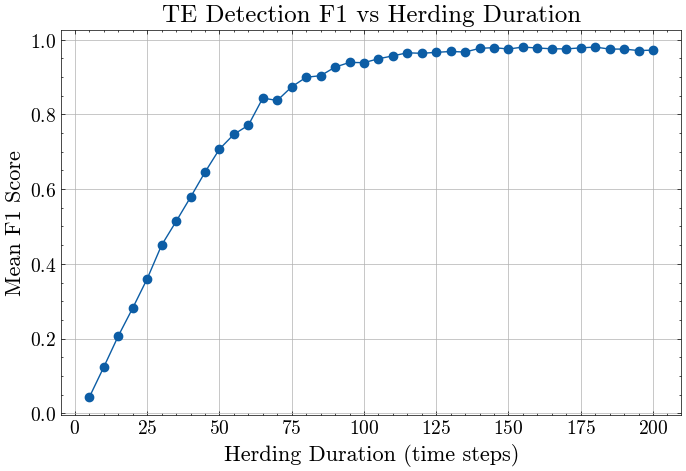

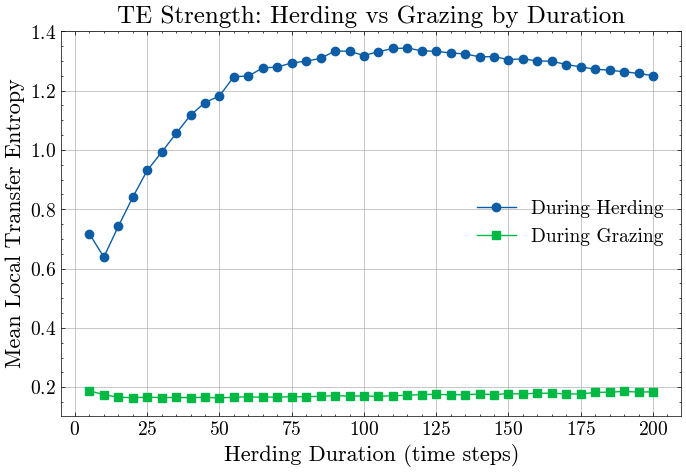

,herding_duration,accuracy,f1,mean_TE_herding,mean_TE_grazing
0,5,0.870641,0.043361,0.717522,0.188177
1,10,0.873547,0.123916,0.638493,0.174699
2,15,0.883166,0.206900,0.742195,0.166350
3,20,0.894589,0.281657,0.840450,0.164503
4,25,0.907114,0.359984,0.930772,0.166327
5,30,0.923948,0.450104,0.992433,0.165137
6,35,0.931363,0.513449,1.055568,0.165353
7,40,0.939880,0.578244,1.117288,0.164832
8,45,0.949198,0.645246,1.159917,0.166093
9,50,0.957515,0.706984,1.182011,0.163324


In [ ]:
import matplotlib.pyplot as plt

def evaluate_herding_duration_effect(
    herding_durations,
    N_runs,
    time_steps,
    num_mares,
    grazing_time,
    stallion_movement_distance,
    stallion_speed,
    k=1
):
    """
    For each herding_duration in herding_durations, run N_runs simulations
    with fixed grazing_time and varying herding_duration, compute LTE at lag k,
    and record detection F1 and average TE strengths.

    Returns a DataFrame with columns:
      herding_duration, run_id, accuracy, f1, mean_TE_herding, mean_TE_grazing
    """
    records = []
    for duration in tqdm(herding_durations, desc="Herding durations"):
        for run_id in range(N_runs):
            ht_start = grazing_time
            ht_end = grazing_time + duration
            sim = simulate_herding_data(
                time_steps=time_steps,
                num_mares=num_mares,
                herding_start=ht_start,
                herding_end=ht_end,
                stallion_movement_distance=stallion_movement_distance,
                stallion_speed=stallion_speed,
                grazing_std_dev=0.1
            )
            mov = compute_movement_series(sim, num_mares)
            te_df = compute_local_transfer_entropy(mov, k=k)

            thr = te_df['local_transfer_entropy'].mean() + te_df['local_transfer_entropy'].std()
            pred = te_df['local_transfer_entropy'] >= thr
            true = te_df['time'].between(ht_start, ht_end)

            acc = accuracy_score(true, pred)
            f1 = f1_score(true, pred)
            mean_te_herd = te_df.loc[true, 'local_transfer_entropy'].mean()
            mean_te_graz = te_df.loc[~true, 'local_transfer_entropy'].mean()

            records.append({
                'herding_duration': duration,
                'run_id': run_id,
                'accuracy': acc,
                'f1': f1,
                'mean_TE_herding': mean_te_herd,
                'mean_TE_grazing': mean_te_graz
            })
    return pd.DataFrame(records)

# Parameters for test
herding_durations = list(range(5, 201, 5))
N_runs = 10
time_steps = 1000
num_mares = 6
grazing_time = 200
stallion_movement_distance = 10
stallion_speed = 1.0
k_lag = 1

# Run the evaluation
df_duration = evaluate_herding_duration_effect(
    herding_durations=herding_durations,
    N_runs=N_runs,
    time_steps=time_steps,
    num_mares=num_mares,
    grazing_time=grazing_time,
    stallion_movement_distance=stallion_movement_distance,
    stallion_speed=stallion_speed,
    k=k_lag
)

# Summarize results by herding_duration
summary_duration = df_duration.groupby('herding_duration').agg({
    'accuracy': 'mean',
    'f1': 'mean',
    'mean_TE_herding': 'mean',
    'mean_TE_grazing': 'mean'
}).reset_index()

# Plot F1 vs herding duration
plt.figure(figsize=(8,5))
plt.plot(summary_duration['herding_duration'], summary_duration['f1'], marker='o')
plt.xlabel('Herding Duration (time steps)')
plt.ylabel('Mean F1 Score')
plt.title('TE Detection F1 vs Herding Duration')
plt.grid(True)
plt.savefig('Revision1.pdf')
plt.show()

# Plot TE strength contrast
plt.figure(figsize=(8,5))
plt.plot(summary_duration['herding_duration'], summary_duration['mean_TE_herding'], marker='o', label='During Herding')
plt.plot(summary_duration['herding_duration'], summary_duration['mean_TE_grazing'], marker='s', label='During Grazing')
plt.xlabel('Herding Duration (time steps)')
plt.ylabel('Mean Local Transfer Entropy')
plt.title('TE Strength: Herding vs Grazing by Duration')
plt.legend()
plt.grid(True)
plt.savefig('Revision2.pdf')
plt.show()

summary_duration

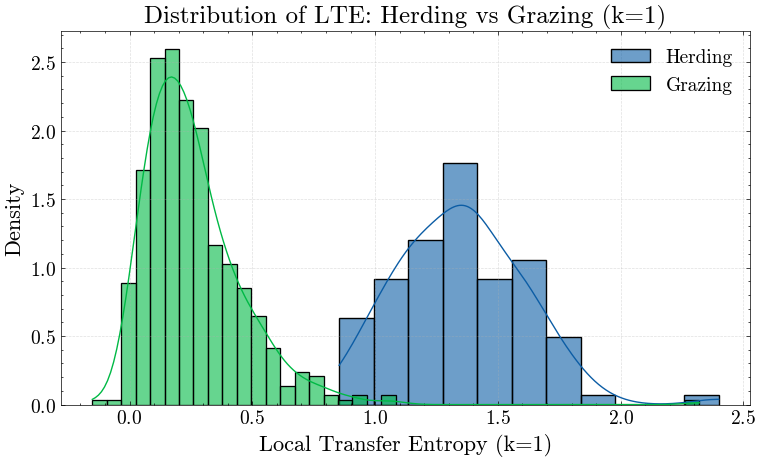

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sim = simulate_herding_data(
    time_steps=600,
    num_mares=6,
    herding_start=200,
    herding_end=300,
    stallion_movement_distance=10,
    stallion_speed=1.0,
    grazing_std_dev=0.1
)
mov = compute_movement_series(sim, num_mares=6)
te_df = compute_local_transfer_entropy(mov, k=1)

# --- 2. Create boolean mask for herding period ---
herding_start, herding_end = 200, 300
is_herd = te_df['time'].between(herding_start, herding_end)

# --- 3. Plot distributions of local TE ---
plt.figure(figsize=(8, 5))
sns.histplot(
    te_df.loc[is_herd, 'local_transfer_entropy'],
    color='C0', label='Herding', kde=True,
    stat='density', alpha=0.6
)
sns.histplot(
    te_df.loc[~is_herd, 'local_transfer_entropy'],
    color='C1', label='Grazing', kde=True,
    stat='density', alpha=0.6
)
plt.legend()
plt.xlabel('Local Transfer Entropy (k=1)')
plt.ylabel('Density')
plt.title('Distribution of LTE: Herding vs Grazing (k=1)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('Revision2.pdf')
plt.show()
